In [1]:
import matplotlib
%matplotlib inline

import sys

sys.path.append("../image")
import krige

sys.path.append("../radar")
import pyart_utils as pu


## You are using the Python ARM Radar Toolkit (Py-ART), an open source
## library for working with weather radar data. Py-ART is partly
## supported by the U.S. Department of Energy as part of the Atmospheric
## Radiation Measurement (ARM) Climate Research Facility, an Office of
## Science user facility.
##
## If you use this software to prepare a publication, please cite:
##
##     JJ Helmus and SM Collis, JORS 2016, doi: 10.5334/jors.119



In [2]:
import pandas as pd

In [3]:
import glob
night = "2017-09-28"
next_night = "2017-09-29"

light_levels_files = glob.glob("../image/kriged/v1/{}/*.csv".format(night))

In [4]:
def process_light_csv(fname):
    df = pd.read_csv(fname)
    df["timestamp"] = pd.to_datetime(fname.split("/")[-1].split(".")[-2])
    return df


In [5]:
light_levels = pd.concat((process_light_csv(f) for f in light_levels_files), ignore_index=True)

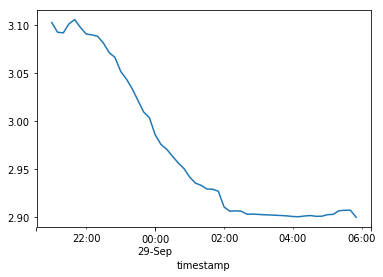

In [6]:
light_levels.groupby("timestamp").z.mean().plot()

In [7]:
def process_radar_csv(fname):
    csv_df = pd.read_csv(fname)
    del csv_df["Unnamed: 0"]
    start = fname.index('KOKX')
    csv_df['Date_Time'] = pd.to_datetime(fname[start+4:start+19],format='%Y%m%d_%H%M%S')
    return csv_df

In [8]:
import glob
radar_dir = "-".join(night.split("-")[:2]) + "/" + night.split("-")[-1]
next_radar_dir = "-".join(next_night.split("-")[:2]) + "/" + next_night.split("-")[-1]
print(radar_dir, next_radar_dir)
fnames = glob.glob("../radar/data/{}/*.filtered.csv".format(radar_dir))\
       + glob.glob("../radar/data/{}/*.filtered.csv".format(next_radar_dir))
og_radar_levels = pd.concat((process_radar_csv(fname)\
                          for fname in fnames))

t_filt = (og_radar_levels.Date_Time >= "{} 21:00".format(night)) &\
         (og_radar_levels.Date_Time <= "{} 06:00".format(next_night))
og_radar_levels = og_radar_levels[t_filt]

2017-09/28 2017-09/29


In [9]:
grouped = og_radar_levels.groupby(["lon", "lat"])
radar_levels = grouped.apply(lambda g: g.set_index("Date_Time").dbzh.resample('10T').mean().reset_index())\
                   .reset_index()

In [10]:
mgd = light_levels.merge(radar_levels, left_on=["timestamp", "x", "y"], right_on=["Date_Time", "lon", "lat"])

In [11]:
import shapely.geometry
import geopandas as gpd

mgd["geometry"] = mgd[["x", "y"]].apply(shapely.geometry.Point, axis=1)
mgd_gdf = gpd.GeoDataFrame(mgd)
mgd_mn = gpd.sjoin(mgd_gdf, krige.ch_df)

In [12]:
import numpy as np
mgd_mn["zexp"] = np.exp(mgd_mn["z"])
def get_diffs(g):
    std = g.sort_values("timestamp")
    diff_light = std["z"][1:].values - std["z"][:-1].values
    diff_light_exp = std["zexp"][1:].values - std["zexp"][:-1].values
    diff_dbzh = std["dbzh"][1:].values - std["dbzh"][:-1].values
    return pd.DataFrame({"light": diff_light, "dbzh": diff_dbzh, 
                         "ts": std["timestamp"][1:].values, 
                         "light_exp": diff_light_exp, 
                         "lat": std["lat"].values[1:],
                         "lon": std["lon"].values[1:]})
grouped = mgd_mn.groupby(['x', 'y']).apply(get_diffs)
rst = grouped.reset_index()

In [13]:
def process_pixel_ts(field):
    def inner_func(pixel_g):
        #pixel_g = pixel_g[pixel_g['ts'] > '{} 00:00:00'.format(next_night)]
        med = pixel_g[field].median()
        std = pixel_g[field].std(ddof=1)
        return np.any((pixel_g[field] > med + 5*std) | (pixel_g[field]< med - 5*std))
    return inner_func
processed = rst.groupby(["lon", "lat"]).apply(process_pixel_ts('light'))

In [14]:
rst2 = processed.reset_index()
rst2["geometry"] = rst2[["lon", "lat"]].apply(shapely.geometry.Point, axis=1)
rst2 = gpd.GeoDataFrame(rst2)
rst2['thing'] = rst2[0].astype(np.int)

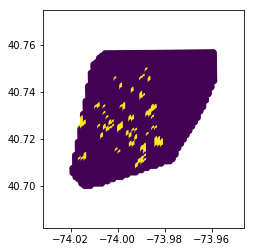

In [15]:
rst2.plot('thing')

In [16]:
lons_lats = set(rst2[rst2[0]][['lon', 'lat']].apply(tuple, axis=1))
filtd = rst[rst[['lon', 'lat']].apply(tuple, axis=1).isin(lons_lats)]
len(mgd_mn), len(mgd_mn[mgd_mn[['lon', 'lat']].apply(tuple, axis=1).isin(lons_lats)])

(122094, 6102)

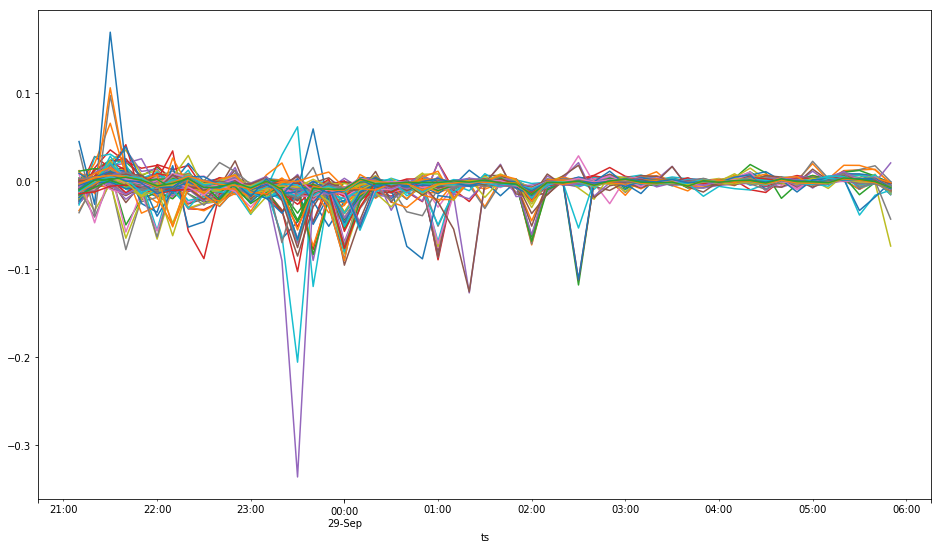

In [17]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1, 1, figsize=(16, 9))
for ix, g in filtd.groupby(["lon", "lat"]):
    g.set_index('ts').light.plot(ax=ax)

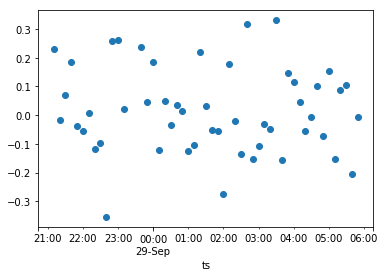

In [18]:
filtd.groupby("ts").apply(lambda g: np.corrcoef(g["dbzh"], g["light"])[0, 1]).plot(style='o')

In [19]:
filtd['timestamp'] = filtd['ts']
filtd['z'] = filtd['light']

/home/cusp/clm633/.conda/envs/pyart/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/home/cusp/clm633/.conda/envs/pyart/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [20]:
def fancy_plot(df):
    fig = plt.figure(figsize=(10,7),facecolor='w')
    ax = fig.add_subplot(111)
    lns1 = ax.plot(df['timestamp'].unique(),df.groupby('timestamp').z.mean(), '-o', label = 'Brightness',alpha=0.3)
    ax2 = ax.twinx()
    lns3 = ax2.plot(df['timestamp'].unique(),df.groupby('timestamp').dbzh.mean(), '-r.', label = 'DBZ',alpha=0.3)


    lns = lns1+lns3
    labs = [l.get_label() for l in lns]
    ax.legend(lns, labs, loc=0)


    fig.autofmt_xdate()
    #ax.grid()
    ax.set_title('Brightness and DBZ, {}'.format(night),fontsize=18)
    #ax.set_xlim('22017-09-30 19:00:33', '2017-10-01 07:51:52')
    #ax.set_xlim('2017-04-13 21:00:00', '2017-04-29 05:00:00')


    #ax.set_xlim('2017-04-14 21:00:00', '2017-04-15 05:00:00')
    #ax.set_xlim('2017-04-18 21:00:00', '2017-04-19 05:00:00')
    #ax.set_xlim('2017-04-23 21:00:00', '2017-04-24 05:00:00')
    #ax.set_xlim('2017-04-24 21:00:00', '2017-04-25 05:00:00')
    #ax.set_xlim('2017-04-27 21:00:00', '2017-04-28 05:00:00')

    #ax.set_ylim(0, 0.08)

    ax.set_xlabel("Time",fontsize=14)
    ax.set_ylabel("Brightness (log cd)",fontsize=14)
    ax2.set_ylabel("Reflectivity (dBZ)",fontsize=14)

    plt.show()

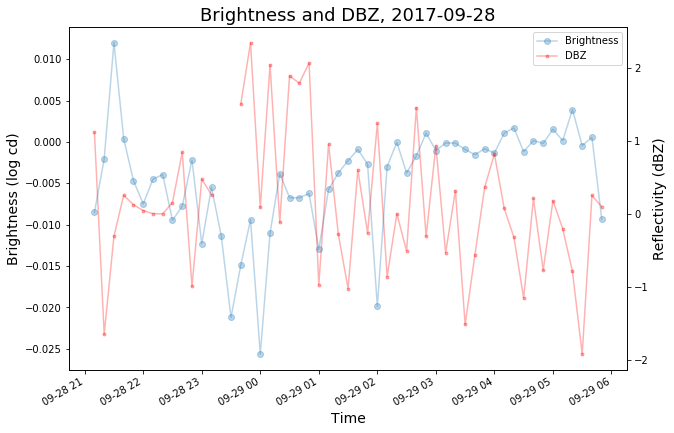

In [21]:
fancy_plot(filtd)

/home/cusp/clm633/.conda/envs/pyart/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


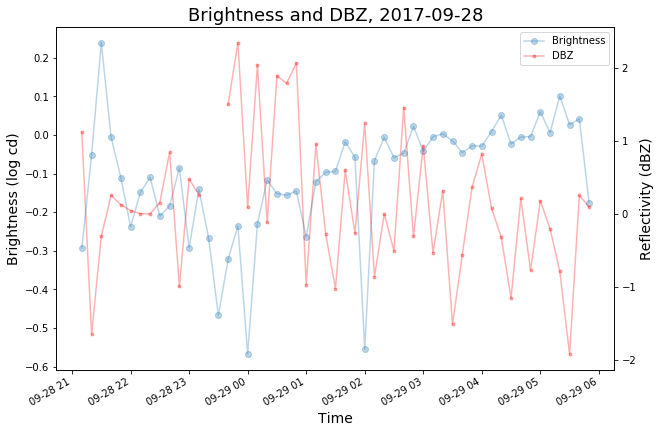

In [22]:
filtd['z'] = filtd['light_exp']
fancy_plot(filtd)